# Pre-process

## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random
import time

import json
import os.path
import gc

from script.module.FeatureProducer import FeatureProducer 
MODEL_FILE_NAME = 'model.txt'

In [2]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if k < k_fold - 1:
            continue
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_1']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ auc score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [3]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## init

In [4]:
fp = FeatureProducer(root='./data')

## load

In [5]:
fp.load_raw()

21:49:53 INFO << load raw data in 19.90s


## preprocess

In [6]:
fp.pre_process()

21:50:22 INFO << parse train_df in 29.24s
21:50:38 INFO << parse test_df in 15.78s
21:50:39 INFO << parse members_df in 0.98s
21:50:55 INFO << parse songs_df in 16.39s
21:50:59 INFO << parse song_extra_info_df in 3.02s


## feature engineering

In [7]:
fp.feature_engineering()

21:51:50 INFO << parse engineering_df in 25.45s
21:52:11 INFO << parse engineering_df in 20.34s


## type to category

In [8]:
fp.self_fit_transform()

21:52:24 INFO << transform "msno" in 2.28s
21:52:28 INFO << transform "song_id" in 4.03s
21:52:29 INFO << transform "source_system_tab" in 1.26s
21:52:30 INFO << transform "source_screen_name" in 1.32s
21:52:32 INFO << transform "source_type" in 1.23s
21:52:32 INFO << transform "1h_source" in 0.39s
21:52:32 INFO << transform "1h_system_tab" in 0.37s
21:52:33 INFO << transform "1h_screen_name" in 0.34s
21:52:33 INFO << transform "1h_source_type" in 0.32s
21:52:33 INFO << transform "song_length" in 0.32s
21:52:35 INFO << transform "genre_ids" in 1.26s
21:52:36 INFO << transform "artist_name" in 1.68s
21:52:38 INFO << transform "composer" in 1.53s
21:52:39 INFO << transform "lyricist" in 1.05s
21:52:40 INFO << transform "language" in 1.06s
21:52:40 INFO << transform "artist_count" in 0.28s
21:52:40 INFO << transform "genre_count" in 0.25s
21:52:41 INFO << transform "composer_count" in 0.23s
21:52:41 INFO << transform "lyricist_count" in 0.20s
21:52:41 INFO << transform "1h_lang" in 0.15s


In [9]:
train_df = fp.train_df
test_df = fp.test_df

assert(train_df.shape[1] == test_df.shape[1])
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 38 columns):
msno                       category
song_id                    category
source_system_tab          category
source_screen_name         category
source_type                category
target                     int64
1h_source                  bool
1h_system_tab              bool
1h_screen_name             bool
1h_source_type             bool
song_length                int32
genre_ids                  category
artist_name                category
composer                   category
lyricist                   category
language                   category
artist_count               int32
genre_count                int32
composer_count             int32
lyricist_count             int32
1h_lang                    bool
1h_song_length             bool
song_year                  int32
1h_song_year               bool
city                       category
bd                         category


## CF natively

In [10]:
import numpy as np
import pandas as pd
import pickle
import implicit
import time
import os
import logging

# self-defined
from script.module.FeatureProducer import FeatureProducer

from scipy.sparse import coo_matrix

In [11]:
class ImplicitProducer(object):

    __TRAIN_FILE_NAME = 'train.csv'
    __TEST_FILE_NAME = 'test.csv'

    def __init__(self, root='./data', factors=10, iterations=15):
        assert os.path.exists(root), '%s not exists!' % root
        self._root = os.path.expanduser(root)

        self._train_df = None
        self._test_df = None
        self._comb_df = None

        self._factors = factors
        self._iterations = iterations

    def prepare(self):
        start = time.time()
        # load train & test set
        self._train_df = pd.read_csv(os.path.join(self._root, self.__TRAIN_FILE_NAME))
        self._test_df = pd.read_csv(os.path.join(self._root, self.__TEST_FILE_NAME))

        self._train_df = self._train_df[['msno', 'song_id', 'target']]
        self._test_df = self._test_df[['msno', 'song_id']]
        self._comb_df = self._train_df.append(self._test_df)

        for column in self._train_df.columns:
            if self._train_df[column].dtype == object:
                self._train_df[column] = self._train_df[column].astype('category')

        for column in self._test_df.columns:
            if self._test_df[column].dtype == object:
                self._test_df[column] = self._test_df[column].astype('category')

        for column in self._comb_df.columns:
            if self._comb_df[column].dtype == object:
                self._comb_df[column] = self._comb_df[column].astype('category')

        logging.info("prepare in %0.2fs" % (time.time() - start))

    def compute(self, is_train):
        assert(isinstance(is_train, bool))

        """
        # generate recommendations for each user and write out to a file
        songs = dict(enumerate(df['song_id'].cat.categories))
        start = time.time()
        user_plays = train_csr_matrix.T.tocsr()

        with open('.out', "w") as o:
            for userid, username in enumerate(df['msno'].cat.categories):
                for songid, score in model.recommend(userid, user_plays, N=2):
                    o.write("%s\t%s\t%s\n" % (username, songs[songid], score))
        logging.debug("generated recommendations in %0.2fs",  time.time() - start)
        """
        if is_train:
            return self.generate_latent_factors(self._train_df, self._train_df)
        else:
            return self.generate_latent_factors(self._test_df, self._train_df)

    def generate_latent_factors(self, df, ref_df):
        model = implicit.als.AlternatingLeastSquares(factors=self._factors, iterations=self._iterations)

        csr_matrix = coo_matrix((ref_df['target'].astype(float),
                                 (ref_df['song_id'].cat.codes, ref_df['msno'].cat.codes)))
        model.fit(csr_matrix)

        item_series = pd.DataFrame(data=ref_df['song_id'].cat.categories.tolist(), columns=['song_id'])
        user_series = pd.DataFrame(data=ref_df['msno'].cat.categories.tolist(), columns=['msno'])

        item_factors_df = pd.DataFrame(data=model.item_factors)
        user_factors_df = pd.DataFrame(data=model.user_factors)
        item_factors_df.columns = ['item_fac_' + str(i) for i in range(self._factors)]
        user_factors_df.columns = ['user_fac_' + str(i) for i in range(self._factors)]

        item_factors_df = item_factors_df.join(item_series)
        user_factors_df = user_factors_df.join(user_series)
        # print(item_factors_df)
        # print(user_factors_df)

        df = df.merge(item_factors_df, on='song_id', how='left')
        df = df.merge(user_factors_df, on='msno', how='left')
        # print(df)
        return df

    @property
    def train_df(self):
        return self._train_df

    @property
    def test_df(self):
        return self._test_df

In [12]:
ip = ImplicitProducer(root='./data')
ip.prepare()

21:53:07 INFO << prepare in 22.02s


In [13]:
train_cf_df = ip.compute(True)
test_cf_df = ip.compute(False)

21:53:13 DEBUG << finished iteration 0 in 0.37065625190734863
21:53:13 DEBUG << finished iteration 1 in 0.249664306640625
21:53:13 DEBUG << finished iteration 2 in 0.2527327537536621
21:53:13 DEBUG << finished iteration 3 in 0.24882054328918457
21:53:14 DEBUG << finished iteration 4 in 0.24675869941711426
21:53:14 DEBUG << finished iteration 5 in 0.24088239669799805
21:53:14 DEBUG << finished iteration 6 in 0.2478349208831787
21:53:14 DEBUG << finished iteration 7 in 0.24360942840576172
21:53:15 DEBUG << finished iteration 8 in 0.24291539192199707
21:53:15 DEBUG << finished iteration 9 in 0.24019289016723633
21:53:15 DEBUG << finished iteration 10 in 0.24535584449768066
21:53:15 DEBUG << finished iteration 11 in 0.24127650260925293
21:53:15 DEBUG << finished iteration 12 in 0.24698686599731445
21:53:16 DEBUG << finished iteration 13 in 0.24649381637573242
21:53:16 DEBUG << finished iteration 14 in 0.24810242652893066
21:53:29 DEBUG << finished iteration 0 in 0.2599833011627197
21:53:29

In [14]:
train_cf_df.drop(['msno', 'song_id', 'target'], axis=1, inplace=True)
test_cf_df.drop(['msno', 'song_id'], axis=1, inplace=True)

In [15]:
train_df = train_df.join(train_cf_df)
test_df = test_df.join(test_cf_df)

# LGBM training

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

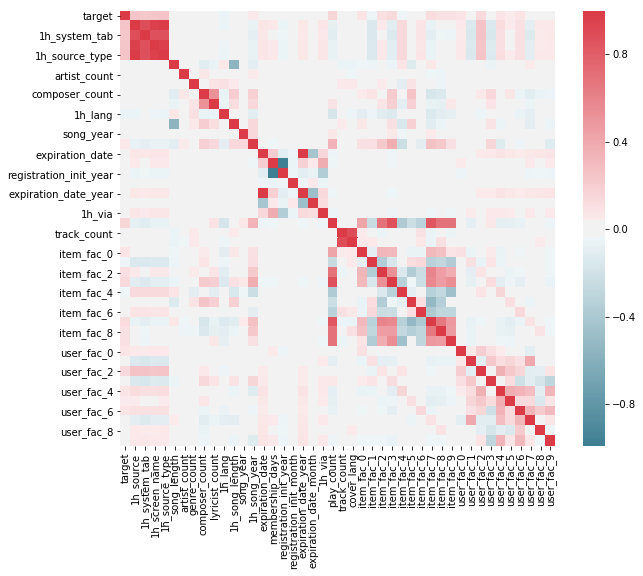

In [16]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Prepare

In [17]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

train_df.head(15)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,1h_source,1h_system_tab,1h_screen_name,1h_source_type,...,user_fac_0,user_fac_1,user_fac_2,user_fac_3,user_fac_4,user_fac_5,user_fac_6,user_fac_7,user_fac_8,user_fac_9
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,False,False,False,False,...,0.085214,0.191165,0.189145,0.070272,0.069798,0.138765,-0.062575,0.051114,-0.062616,0.002772
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,-0.009257,-0.032589,0.046747,0.028940,0.073362,0.022887,0.095853,0.035650,-0.001603,0.069971
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,-0.009257,-0.032589,0.046747,0.028940,0.073362,0.022887,0.095853,0.035650,-0.001603,0.069971
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,-0.009257,-0.032589,0.046747,0.028940,0.073362,0.022887,0.095853,0.035650,-0.001603,0.069971
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,False,False,False,False,...,0.085214,0.191165,0.189145,0.070272,0.069798,0.138765,-0.062575,0.051114,-0.062616,0.002772
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,False,False,False,False,...,0.085214,0.191165,0.189145,0.070272,0.069798,0.138765,-0.062575,0.051114,-0.062616,0.002772
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,-0.009257,-0.032589,0.046747,0.028940,0.073362,0.022887,0.095853,0.035650,-0.001603,0.069971
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,False,False,False,False,...,0.085214,0.191165,0.189145,0.070272,0.069798,0.138765,-0.062575,0.051114,-0.062616,0.002772
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,True,True,True,True,...,0.037222,0.050001,0.050223,0.085679,0.125906,0.046703,-0.071480,-0.059286,0.030356,0.033681
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,True,True,True,True,...,0.037222,0.050001,0.050223,0.085679,0.125906,0.046703,-0.071480,-0.059286,0.030356,0.033681


## Core

In [18]:
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
#    'max_depth': 10,
    'num_leaves': 2 ** 7,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=100)
print(cv_score)

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=100, verbose_eval=5)
y_test = model.predict(x_test)

# When CV, valid_0 means the front 75% training, the last 25% validating
#          valid_1 means the front 75% training, the last "len(test set)" validating
#
# When LGBM running, valid_0 means 100% training, the last "len(test set)" validating.
#
# Use CV valid_0 auc score to predict result!

[5]	valid_0's auc: 0.697739	valid_1's auc: 0.710484
[10]	valid_0's auc: 0.710413	valid_1's auc: 0.725004
[15]	valid_0's auc: 0.722119	valid_1's auc: 0.738115
[20]	valid_0's auc: 0.727619	valid_1's auc: 0.74562
[25]	valid_0's auc: 0.733409	valid_1's auc: 0.752631
[30]	valid_0's auc: 0.736759	valid_1's auc: 0.757307
[35]	valid_0's auc: 0.73885	valid_1's auc: 0.760565
[40]	valid_0's auc: 0.740979	valid_1's auc: 0.763667
[45]	valid_0's auc: 0.742724	valid_1's auc: 0.766285
[50]	valid_0's auc: 0.743455	valid_1's auc: 0.767884
[55]	valid_0's auc: 0.74456	valid_1's auc: 0.769843
[60]	valid_0's auc: 0.746103	valid_1's auc: 0.771944
[65]	valid_0's auc: 0.746617	valid_1's auc: 0.773122
[70]	valid_0's auc: 0.746992	valid_1's auc: 0.774164
[75]	valid_0's auc: 0.747681	valid_1's auc: 0.775481
[80]	valid_0's auc: 0.748318	valid_1's auc: 0.776697
[85]	valid_0's auc: 0.748487	valid_1's auc: 0.777508
[90]	valid_0's auc: 0.748618	valid_1's auc: 0.778057
[95]	valid_0's auc: 0.748687	valid_1's auc: 0.7785

## Feature importances

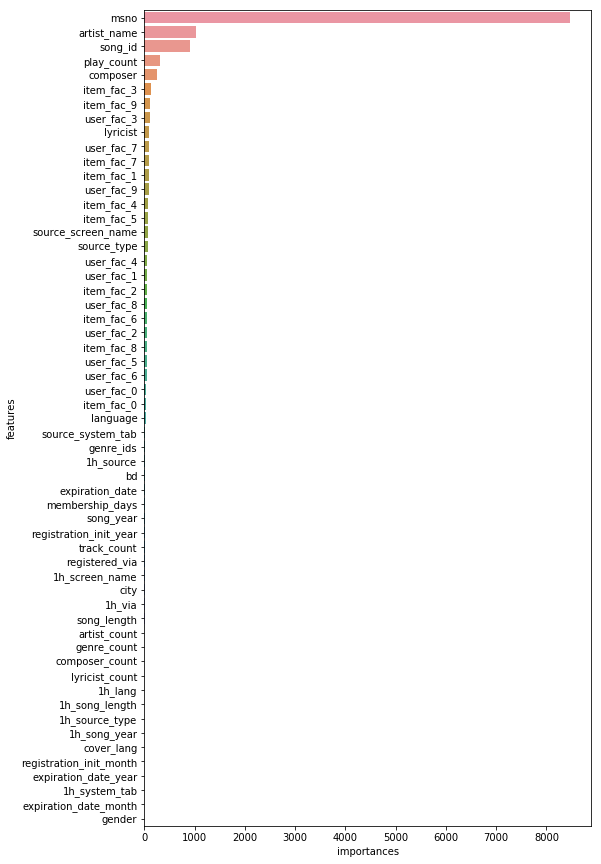

In [19]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

## Output

In [20]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('data/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 58.5 MB
